In [22]:
import model_utils
import pandas as pd

merged_hornsea = pd.read_parquet("preprocessed_hornsea_with_energy.parquet")
merged_pes = pd.read_parquet("preprocessed_pes_with_energy.parquet")

In [ ]:
from Preprocessing import * 

prep = Preprocessing()

merged_hornsea = prep.perform_preprocessing_pipeline(geo_data_dict = {"dwd_icon_eu_hornsea":"nc_files", "ncep_gfs_hornsea":"nc_files"},
                                              deployment = False, merge_with_outage_data = True, json_file_path = "nc_files/REMIT", energy_data_dict = {"Energy_data":"csv_files"},
                                              non_numerical_columns = ["unavailabilityType", "affectedUnit"],
                                              fft = False, )

merged_pes = prep.perform_preprocessing_pipeline(geo_data_dict = {"dwd_icon_eu_pes":"nc_files", "ncep_gfs_pes":"nc_files"},
          deployment = False, merge_with_outage_data = False, energy_data_dict = {"Energy_data":"csv_files"},
                                              non_numerical_columns = ["unavailabilityType", "affectedUnit"],
                                              fft = False, ) 

merged_demand = prep.perform_preprocessing_pipeline(geo_data_dict = {"dwd_icon_eu_demand":"nc_files", "ncep_gfs_demand":"nc_files"},
          deployment = False, merge_with_outage_data = True, energy_data_dict = {"Energy_data":"csv_files"},
                                              non_numerical_columns = ["unavailabilityType", "affectedUnit"],
                                              fft = False, )

INFO:root:Perform data cleaning on the weather data...


In [3]:
merged_hornsea.to_parquet("preprocessed_hornsea_with_energy.parquet")
merged_pes.to_parquet("preprocessed_pes_with_energy.parquet")
merged_demand.to_parquet("preprocessed_demand_with_energy.parquet")

In [ ]:
import comp_utils


def create_submission_data(original_data, wind_prediction, solar_prediction, date:str, api_key_file:str = "team_key.txt"):

    rebase_api_client = comp_utils.RebaseAPI(api_key = open(api_key_file).read())
    # read the required timestamps for the next day
    market_day = pd.DataFrame({"datetime":comp_utils.day_ahead_market_times(today_date=pd.to_datetime(date))})

    prediction = dict()

    for key in wind_prediction.keys():
        prediction[key] = wind_prediction[key] + solar_prediction[key]

    # get the datetime values from the data which was used to predict the forecast
    index = original_data[-prediction["0.1"].shape[0]:].index
    # merge the predictions with the timestamps to make a prediction
    forecasts = pd.DataFrame(prediction, index = index).reset_index().merge(market_day, left_on = "dtm", right_on = "datetime")
    forecasts.columns = ["dtm", "10", "20", "30", "40", "50", "60", "70", "80", "90", "datetime"]

    submissions = list()

    for index, row in forecasts.iterrows():
        submissions.append({"timestamp": str(pd.to_datetime(row["dtm"])).replace(" ", "T"),
                            "market_bid": row["50"],
                            "probalistic_forecast": row[["10", "20", "30", "40", "50", "60", "70", "80", "90"]].to_dict()})
        
    return {"market_day": date, "submissions": submissions}


#create_submission_data(merged_hornsea, wind_pred, solar_pred, "2024-05-17")

In [10]:
import importlib
from Preprocessing import *

feature_engineerer_wind = FeatureEngineerer(label = 'Wind_MWh_credit', columns_to_ohe = ['unavailabilityType', 'affectedUnit', "outage"])
feature_engineerer_wind.perform_feature_engineering(merged_hornsea, deployment = False)

feature_engineerer_solar = FeatureEngineerer(label = "Solar_MWh_credit")
feature_engineerer_solar.perform_feature_engineering(merged_pes, deployment = False)

merged_pes_simple = merged_pes[['solar_down_rad', 'Solar_MWh_credit', 'Wind_MWh_credit']]
feature_engineerer_solar_baseline = FeatureEngineerer(label = 'Solar_MWh_credit')
feature_engineerer_solar_baseline.perform_feature_engineering(merged_pes_simple, deployment = False)

merged_hornsea_simple = merged_hornsea[['wind_speed_100', 'Solar_MWh_credit', 'Wind_MWh_credit']]
feature_engineerer_wind_baseline = FeatureEngineerer(label = 'Wind_MWh_credit')
feature_engineerer_wind_baseline.perform_feature_engineering(merged_hornsea_simple, deployment = False)

INFO:root:No features found to onehotencode.


In [5]:
from Preprocessing import * 

prep = Preprocessing()

merged_pes2 = prep.perform_preprocessing_pipeline(geo_data_dict = {"dwd_icon_eu_pes":"api_files", "ncep_gfs_pes":"api_files"},
          deployment = True, merge_with_outage_data = False, energy_data_dict = {"Energy_Data":"api_files"},
                                              non_numerical_columns = ["unavailabilityType", "affectedUnit"],
                                              fft = False, )

merged_hornsea2 = prep.perform_preprocessing_pipeline(geo_data_dict = {"dwd_icon_eu_hornsea":"api_files", "ncep_gfs_hornsea":"api_files"},
          deployment = True, merge_with_outage_data = True, energy_data_dict = {"Energy_Data":"api_files"},
                                              non_numerical_columns = ["unavailabilityType", "affectedUnit"],
                                              fft = False, )

INFO:root:Perform data cleaning on the weather data...
INFO:root:Merge weather stations...
INFO:root:Merge with energy data...
INFO:root:Preprocessing done!
INFO:root:Perform data cleaning on the weather data...
INFO:root:Merge weather stations...
INFO:root:Merge with outages data (REMIT)...
c:\Users\danie\Documents\AWP2_Repo\awp2\Preprocessing.py:325: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  outages_df = pd.concat([outages_df, json_data_with_date_ranges])
c:\Users\danie\Documents\AWP2_Repo\awp2\Preprocessing.py:325: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the rele

Index(['dtm', 'generation_mw', 'installed_capacity_mwp', 'capacity_mwp'], dtype='object')
                    dtm  generation_mw  installed_capacity_mwp  capacity_mwp
0  2024-10-10T22:00:00Z            0.0             2956.745251   2779.348110
1  2024-10-10T22:30:00Z            0.0             2956.745251   2779.348110
2  2024-10-10T23:00:00Z            0.0             2956.745251   2779.348110
3  2024-10-10T23:30:00Z            0.0             2956.745251   2779.283368
4  2024-10-11T00:00:00Z            0.0             2956.745251   2779.283355


INFO:root:Preprocessing done!


In [12]:
feature_engineerer_wind.perform_feature_engineering(merged_hornsea2, deployment = True)

In [11]:
feature_engineerer_solar.perform_feature_engineering(merged_pes2, deployment = True)

### __Wind Energy Forecast__

__baseline__

In [4]:
import model_utils
import numpy as np
import importlib
importlib.reload(model_utils)

quantiles = np.arange(0.1, 1.0, 0.1)

# Specify model save directory
model_save_dir_qr = "qr_model_wind"

qr_model_wind = model_utils.QuantileRegressorModel(feature_engineerer_wind_baseline, quantiles, model_save_dir=model_save_dir_qr, load_pretrained=True)
qr_model_wind.train_and_predict()  # This will skip training for already loaded models
print(f"Quantile Regressor Pinball Score: {qr_model_wind.pinball_score()}")

Loaded pretrained Quantile Regressor model for quantile 0.1 from qr_model_wind\qr_model_quantile_0.1.pkl
Loaded pretrained Quantile Regressor model for quantile 0.2 from qr_model_wind\qr_model_quantile_0.2.pkl
Loaded pretrained Quantile Regressor model for quantile 0.30000000000000004 from qr_model_wind\qr_model_quantile_0.30000000000000004.pkl
Loaded pretrained Quantile Regressor model for quantile 0.4 from qr_model_wind\qr_model_quantile_0.4.pkl
Loaded pretrained Quantile Regressor model for quantile 0.5 from qr_model_wind\qr_model_quantile_0.5.pkl
Loaded pretrained Quantile Regressor model for quantile 0.6 from qr_model_wind\qr_model_quantile_0.6.pkl
Loaded pretrained Quantile Regressor model for quantile 0.7000000000000001 from qr_model_wind\qr_model_quantile_0.7000000000000001.pkl
Loaded pretrained Quantile Regressor model for quantile 0.8 from qr_model_wind\qr_model_quantile_0.8.pkl
Loaded pretrained Quantile Regressor model for quantile 0.9 from qr_model_wind\qr_model_quantile_0

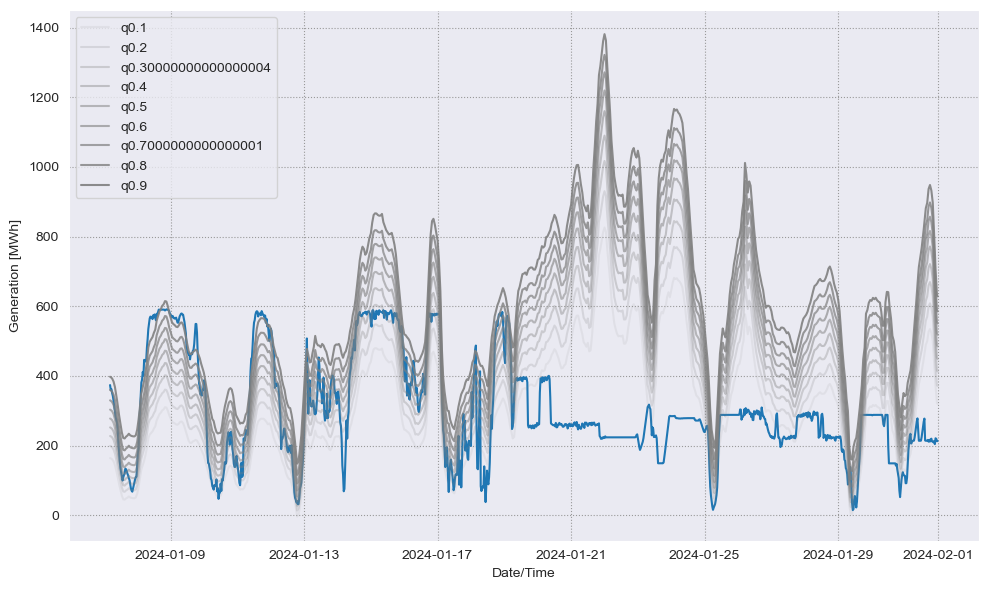

In [5]:
qr_model_wind.plot_quantils(feature_engineerer_wind_baseline.y_test, qr_model_wind.q_predictions, quantiles=np.arange(0.1, 1.0, 0.1))

__xgboost__

In [35]:
importlib.reload(model_utils)
import numpy as np

quantiles = np.arange(0.1, 1.0, 0.1)

model_save_dir_xgboost = "xgboost_model_wind"
hyperparams = {
            # Use the quantile objective function.
            "objective": "reg:quantileerror",
            "tree_method": "hist",
            "quantile_alpha": quantiles,
            "learning_rate": 0.01,
            "max_depth": 8
        }




xgboost_model_wind = model_utils.XGBoostModel(feature_engineerer_wind, quantiles=quantiles, model_save_dir=model_save_dir_xgboost, load_pretrained=False, hyperparams=hyperparams, num_boost_round=45, early_stopping_rounds=10)
xgboost_model_wind.train_and_predict()  # This will skip training if the model is already loaded
print(f"XGBoost Pinball Score: {xgboost_model_wind.pinball_score()}")

[0]	Train-quantile:98.07741	Val-quantile:90.10948
[1]	Train-quantile:97.02596	Val-quantile:89.30330
[2]	Train-quantile:95.98593	Val-quantile:88.51152
[3]	Train-quantile:94.95850	Val-quantile:87.72979
[4]	Train-quantile:93.94294	Val-quantile:86.95775
[5]	Train-quantile:92.94035	Val-quantile:86.19631
[6]	Train-quantile:91.94893	Val-quantile:85.44439
[7]	Train-quantile:90.96906	Val-quantile:84.70198
[8]	Train-quantile:89.99928	Val-quantile:83.96877
[9]	Train-quantile:89.04126	Val-quantile:83.24497
[10]	Train-quantile:88.09402	Val-quantile:82.53144
[11]	Train-quantile:87.15834	Val-quantile:81.83003
[12]	Train-quantile:86.23448	Val-quantile:81.14272
[13]	Train-quantile:85.31832	Val-quantile:80.45519
[14]	Train-quantile:84.41554	Val-quantile:79.78112
[15]	Train-quantile:83.52334	Val-quantile:79.11417
[16]	Train-quantile:82.63906	Val-quantile:78.45591
[17]	Train-quantile:81.76540	Val-quantile:77.80409
[18]	Train-quantile:80.90267	Val-quantile:77.16226
[19]	Train-quantile:80.04857	Val-quantile

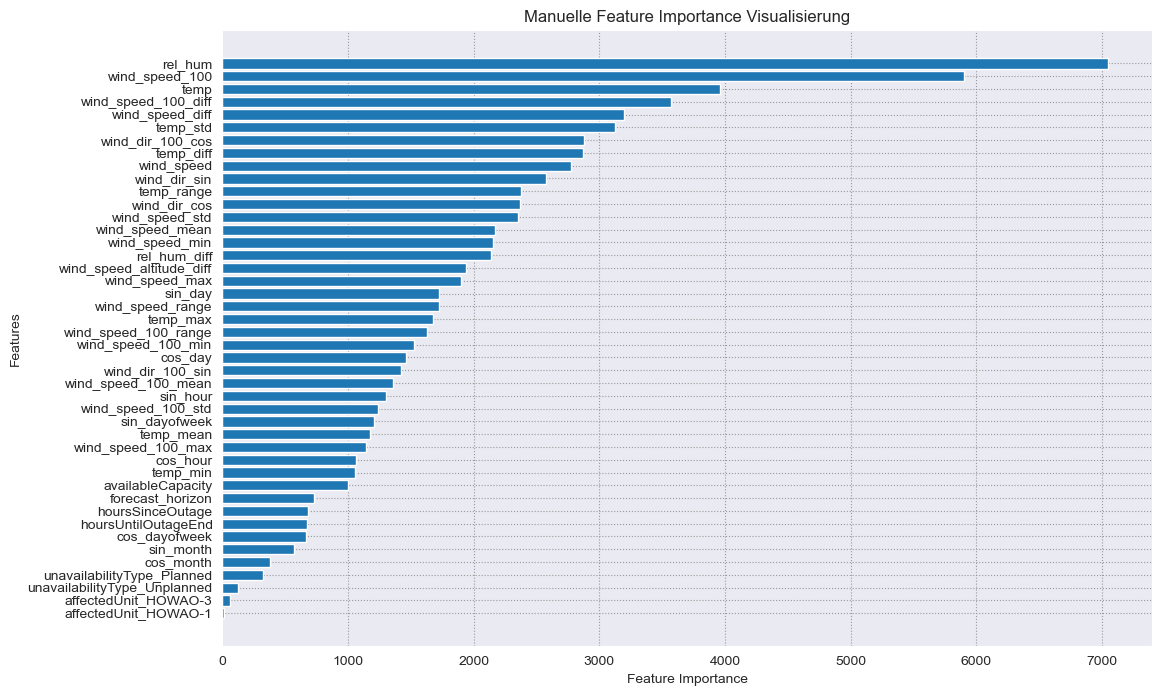

In [34]:
xgboost_model_wind.plot_feature_importance()

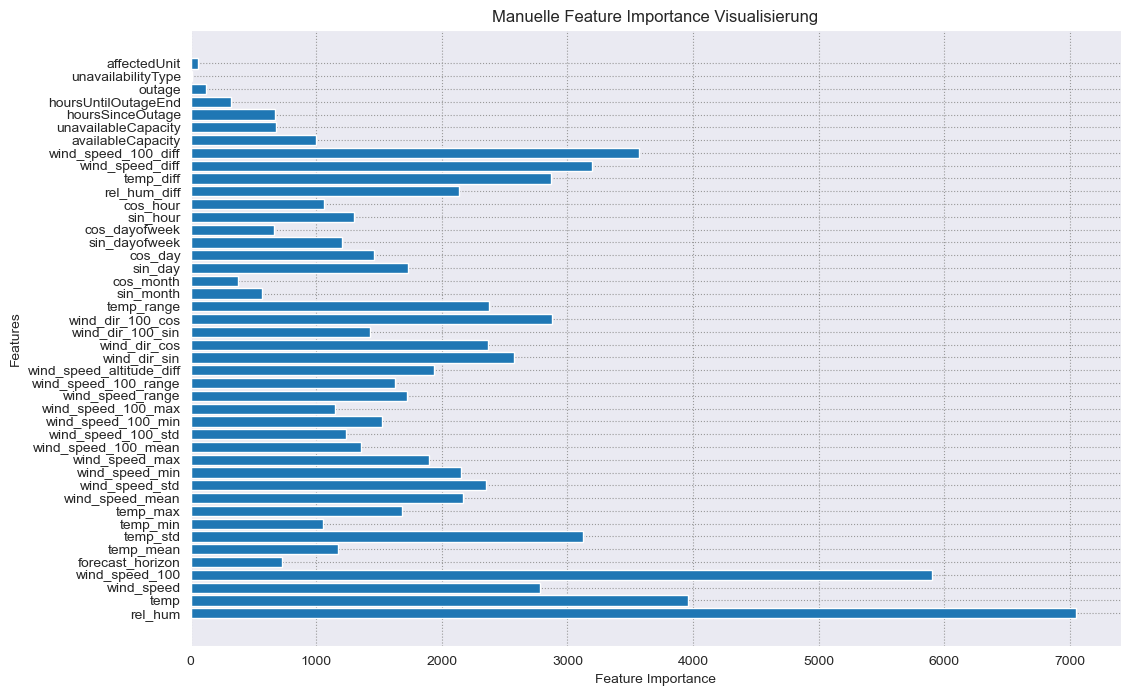

In [7]:
# Feature-Wichtigkeiten abrufen
import matplotlib.pylab as plt

booster = xgboost_model_wind.booster
importance_dict = booster.get_score(importance_type='weight')
# In ein Pandas DataFrame umwandeln für einfache Verarbeitung
importance_df = pd.DataFrame(list(importance_dict.items()), columns=['Feature', 'Importance'])
importance_df["feature_name"] = merged_hornsea.drop(['Solar_MWh_credit', 'Wind_MWh_credit'], axis=1).columns
# Nach Wichtigkeit sortieren
# importance_df = importance_df.sort_values(by='Index', ascending=False)

# Plotten
plt.figure(figsize=(12, 8))  # Größe anpassen
plt.barh(importance_df['feature_name'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.grid(True)
plt.title('Manuelle Feature Importance Visualisierung')
plt.show()

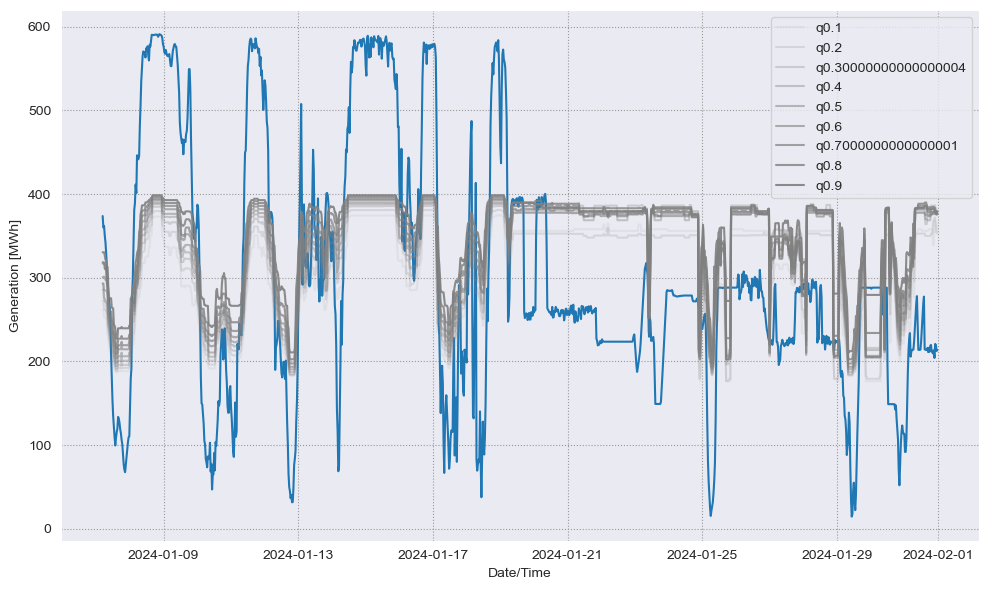

In [8]:
xgboost_model_wind.plot_quantils(x=feature_engineerer_wind.y_test, y=xgboost_model_wind.q_predictions, quantiles=np.arange(0.1, 1.0, 0.1))

### __Solar Energy Forecast__

__baseline modell__

In [9]:
quantiles = np.arange(0.1, 1.0, 0.1)

# Specify model save directory
model_save_dir_qr = "qr_model_solar"

qr_model_solar = model_utils.QuantileRegressorModel(feature_engineerer_solar_baseline, quantiles, model_save_dir=model_save_dir_qr, load_pretrained=True)
qr_model_solar.train_and_predict()  # This will skip training for already loaded models
print(f"Quantile Regressor Pinball Score: {qr_model_solar.pinball_score()}")

Loaded pretrained Quantile Regressor model for quantile 0.1 from qr_model_solar\qr_model_quantile_0.1.pkl
Loaded pretrained Quantile Regressor model for quantile 0.2 from qr_model_solar\qr_model_quantile_0.2.pkl
Loaded pretrained Quantile Regressor model for quantile 0.30000000000000004 from qr_model_solar\qr_model_quantile_0.30000000000000004.pkl
Loaded pretrained Quantile Regressor model for quantile 0.4 from qr_model_solar\qr_model_quantile_0.4.pkl
Loaded pretrained Quantile Regressor model for quantile 0.5 from qr_model_solar\qr_model_quantile_0.5.pkl
Loaded pretrained Quantile Regressor model for quantile 0.6 from qr_model_solar\qr_model_quantile_0.6.pkl
Loaded pretrained Quantile Regressor model for quantile 0.7000000000000001 from qr_model_solar\qr_model_quantile_0.7000000000000001.pkl
Loaded pretrained Quantile Regressor model for quantile 0.8 from qr_model_solar\qr_model_quantile_0.8.pkl
Loaded pretrained Quantile Regressor model for quantile 0.9 from qr_model_solar\qr_model_q

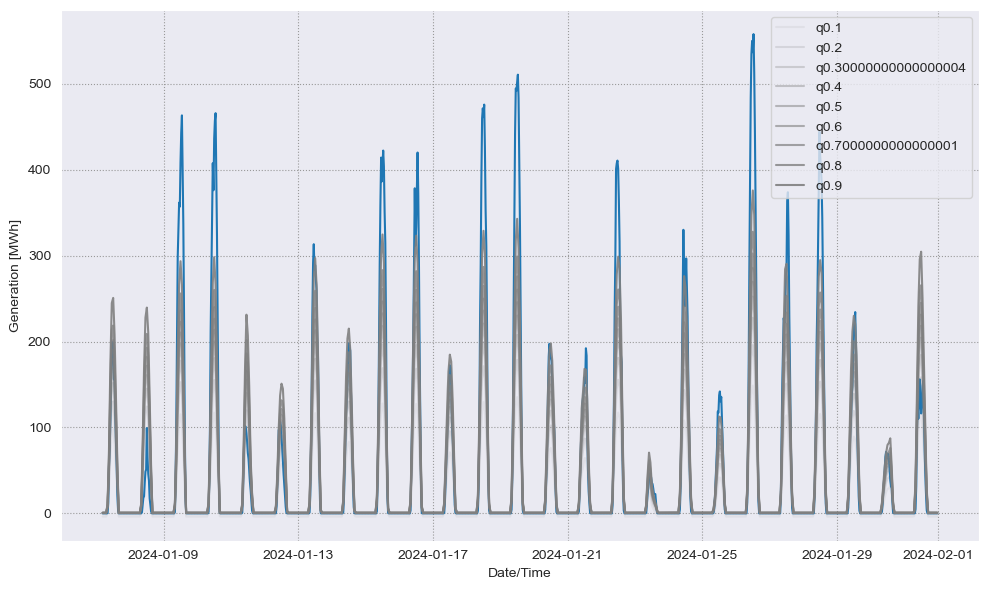

In [10]:
qr_model_solar.plot_quantils(x=feature_engineerer_solar_baseline.y_test, y=qr_model_solar.q_predictions, quantiles=np.arange(0.1, 1.0, 0.1))

__xgboost__

In [10]:
quantiles = np.arange(0.1, 1.0, 0.1)

model_save_dir_xgboost = "xgboost_model_solar"

xgboost_model_solar = model_utils.XGBoostModel(feature_engineerer_solar, quantiles=quantiles, model_save_dir=model_save_dir_xgboost, load_pretrained=False)
xgboost_model_solar.train_and_predict()  # This will skip training if the model is already loaded
print(f"XGBoost Pinball Score: {xgboost_model_solar.pinball_score()}")

[0]	Train-quantile:44.13711	Val-quantile:92.39619
[1]	Train-quantile:42.29035	Val-quantile:88.18365
[2]	Train-quantile:40.55821	Val-quantile:84.24039
[3]	Train-quantile:38.91136	Val-quantile:80.39995
[4]	Train-quantile:37.33778	Val-quantile:76.78529
[5]	Train-quantile:35.83333	Val-quantile:73.30171
[6]	Train-quantile:34.39310	Val-quantile:69.98754
[7]	Train-quantile:33.02647	Val-quantile:66.85015
[8]	Train-quantile:31.70823	Val-quantile:63.88203
[9]	Train-quantile:30.45575	Val-quantile:61.09073
[10]	Train-quantile:29.24477	Val-quantile:58.43921
[11]	Train-quantile:28.10669	Val-quantile:55.88483
[12]	Train-quantile:27.01545	Val-quantile:53.55809
[13]	Train-quantile:25.98487	Val-quantile:51.35945
[14]	Train-quantile:25.00727	Val-quantile:49.34656
[15]	Train-quantile:24.07807	Val-quantile:47.33327
[16]	Train-quantile:23.18729	Val-quantile:45.37388
[17]	Train-quantile:22.34714	Val-quantile:43.62021
[18]	Train-quantile:21.53669	Val-quantile:41.84246
[19]	Train-quantile:20.77310	Val-quantile

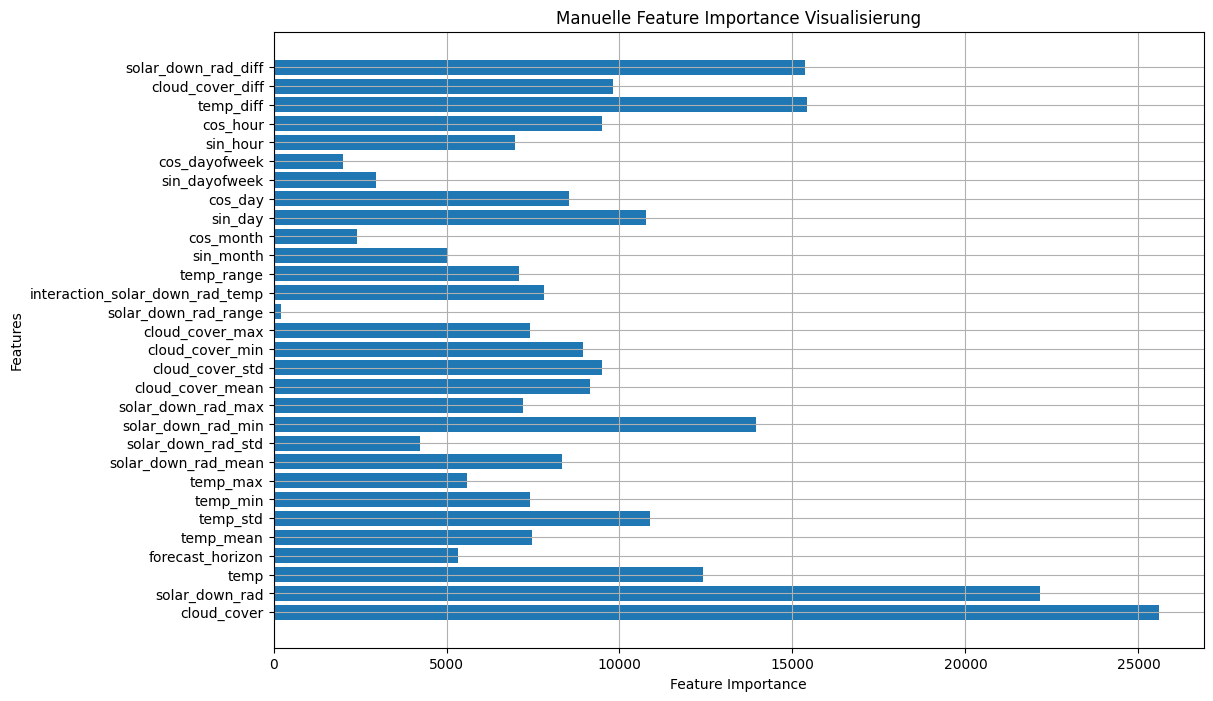

In [16]:
# Feature-Wichtigkeiten abrufen
import matplotlib.pylab as plt

booster = xgboost_model_solar.booster
importance_dict = booster.get_score(importance_type='weight')

# In ein Pandas DataFrame umwandeln für einfache Verarbeitung
importance_df = pd.DataFrame(list(importance_dict.items()), columns=['Feature', 'Importance'])
importance_df["feature_name"] = merged_pes.drop(['Solar_MWh_credit', 'Wind_MWh_credit'], axis=1).columns
# Nach Wichtigkeit sortieren
# importance_df = importance_df.sort_values(by='Index', ascending=False)

# Plotten
plt.figure(figsize=(12, 8))  # Größe anpassen
plt.barh(importance_df['feature_name'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.grid(True)
plt.title('Manuelle Feature Importance Visualisierung')
plt.show()

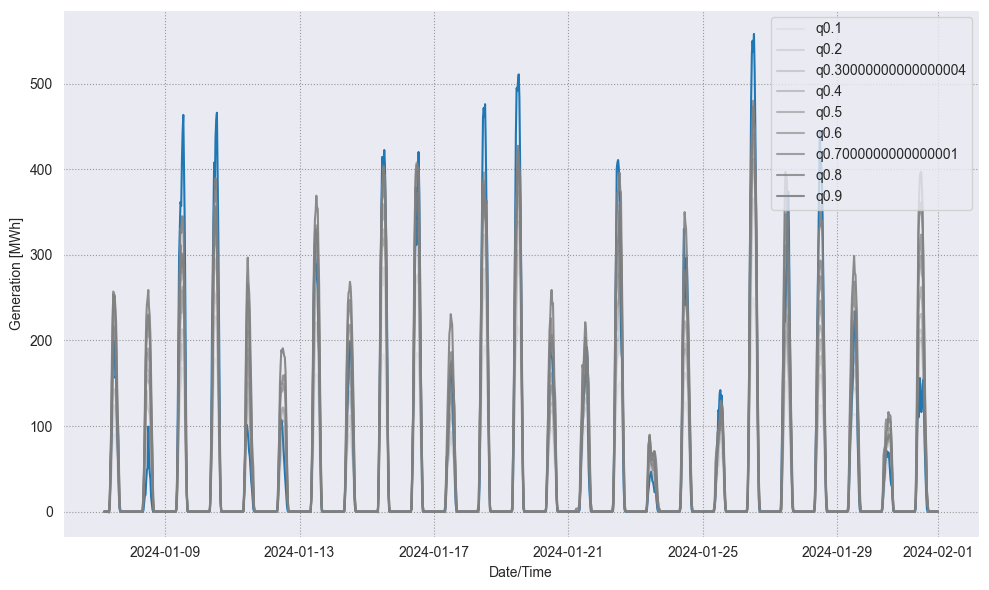

In [17]:
xgboost_model_solar.plot_quantils(x=feature_engineerer_solar.y_test, y=xgboost_model_solar.q_predictions, quantiles=np.arange(0.1, 1.0, 0.1))

### __Lightgbm implementation__

In [18]:
quantiles = np.arange(0.1, 1.0, 0.1)

# Specify model save directory
model_save_dir_qr = "lgbm_model_wind"

lgbm_model_wind = model_utils.LGBMRegressorModel(feature_engineerer_wind, quantiles, model_save_dir=model_save_dir_qr, load_pretrained=False)
lgbm_model_wind.train_and_predict()  # This will skip training for already loaded models
print(f"Quantile Regressor Pinball Score: {lgbm_model_wind.pinball_score()}")

[LightGBM] [Info] Total Bins 8155
[LightGBM] [Info] Number of data points in the train set: 48168, number of used features: 50
[LightGBM] [Info] Start training from score 9.724700
Training until validation scores don't improve for 50 rounds
[50]	train's quantile: 10.1477	valid's quantile: 15.3798
[100]	train's quantile: 9.3723	valid's quantile: 15.3115
[150]	train's quantile: 8.85279	valid's quantile: 15.2727
Early stopping, best iteration is:
[146]	train's quantile: 8.86304	valid's quantile: 15.2661
Saved Quantile Regressor model for quantile 0.1 to lgbm_model_wind\qr_model_quantile_0.1.pkl
[LightGBM] [Info] Total Bins 8155
[LightGBM] [Info] Number of data points in the train set: 48168, number of used features: 50
[LightGBM] [Info] Start training from score 45.381004
Training until validation scores don't improve for 50 rounds
[50]	train's quantile: 14.462	valid's quantile: 21.0098
[100]	train's quantile: 13.6989	valid's quantile: 20.8239
Early stopping, best iteration is:
[89]	train

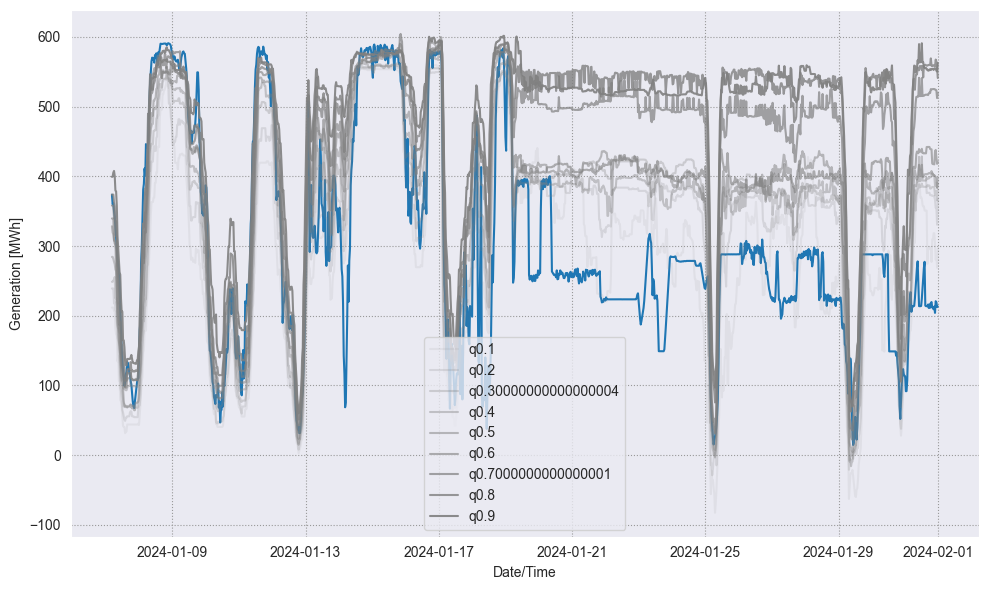

In [19]:
lgbm_model_wind.plot_quantils(feature_engineerer_wind.y_test, lgbm_model_wind.q_predictions, quantiles)

In [20]:
quantiles = np.arange(0.1, 1.0, 0.1)

# Specify model save directory
model_save_dir_qr = "lgbm_model_solar"

lgbm_model_solar = model_utils.LGBMRegressorModel(feature_engineerer_solar, quantiles, model_save_dir=model_save_dir_qr, load_pretrained=False)
lgbm_model_solar.train_and_predict()  # This will skip training for already loaded models
print(f"Quantile Regressor Pinball Score: {lgbm_model_solar.pinball_score()}")

[LightGBM] [Info] Total Bins 5805
[LightGBM] [Info] Number of data points in the train set: 48168, number of used features: 30
Training until validation scores don't improve for 50 rounds
[50]	train's quantile: 5.09227	valid's quantile: 5.36952
[100]	train's quantile: 4.39179	valid's quantile: 5.02654
[150]	train's quantile: 4.3137	valid's quantile: 4.9897
[200]	train's quantile: 4.2689	valid's quantile: 4.9739
[250]	train's quantile: 4.26053	valid's quantile: 4.97326
[300]	train's quantile: 4.25864	valid's quantile: 4.97093
Early stopping, best iteration is:
[296]	train's quantile: 4.25872	valid's quantile: 4.97074
Saved Quantile Regressor model for quantile 0.1 to lgbm_model_solar\qr_model_quantile_0.1.pkl
[LightGBM] [Info] Total Bins 5805
[LightGBM] [Info] Number of data points in the train set: 48168, number of used features: 30
Training until validation scores don't improve for 50 rounds
[50]	train's quantile: 7.33284	valid's quantile: 8.31634
[100]	train's quantile: 6.40803	valid

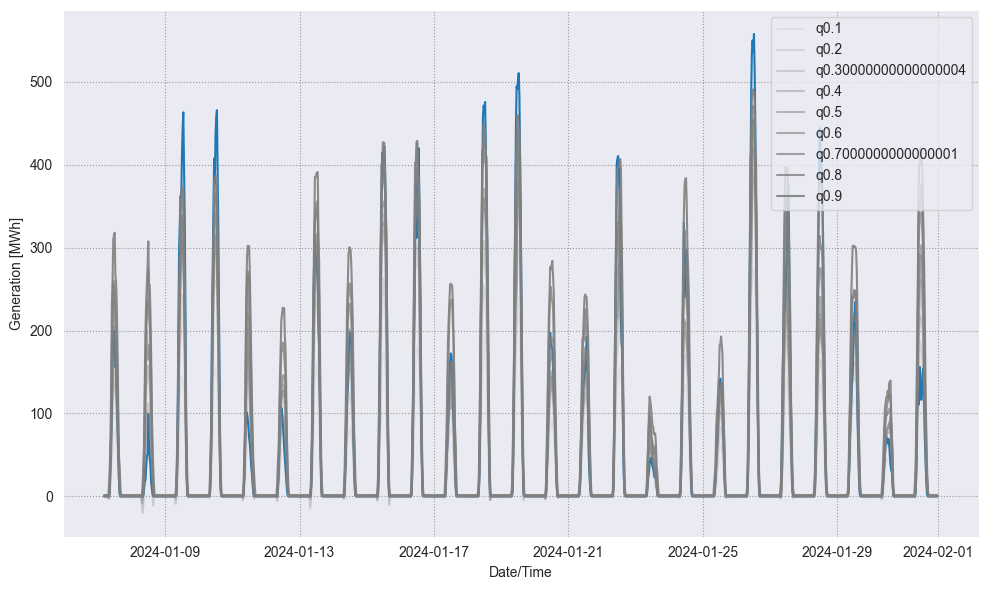

In [21]:
lgbm_model_solar.plot_quantils(feature_engineerer_solar.y_test, lgbm_model_solar.q_predictions, quantiles)

In [22]:
from functools import partial
from itertools import chain
import torch
import torch.nn as nn

class q_model(nn.Module):
    def __init__(self, 
                 quantiles, 
                 in_shape=50,  
                 dropout=0.5):     
        super().__init__()
        self.quantiles = quantiles
        self.num_quantiles = len(quantiles)
        
        self.in_shape = in_shape
        self.out_shape = len(quantiles)
        self.dropout = dropout
        self.build_model()
        self.init_weights()
        
    def build_model(self): 
        self.base_model = nn.Sequential(
            nn.Linear(self.in_shape, 64),
            nn.ReLU(),
            # nn.BatchNorm1d(64),
            nn.Dropout(self.dropout),
            nn.Linear(64, 64),
            nn.ReLU(),
            # nn.BatchNorm1d(64),
            nn.Dropout(self.dropout),
        )
        final_layers = [
            nn.Linear(64, 1) for _ in range(len(self.quantiles))
        ]
        self.final_layers = nn.ModuleList(final_layers)
        
    def init_weights(self):
        for m in chain(self.base_model, self.final_layers):
            if isinstance(m, nn.Linear):
                nn.init.orthogonal_(m.weight)
                nn.init.constant_(m.bias, 0)        
        
    def forward(self, x):
        tmp_ = self.base_model(x)
        return torch.cat([layer(tmp_) for layer in self.final_layers], dim=1)

In [23]:
class QuantileLoss(nn.Module):
    def __init__(self, quantiles):
        super().__init__()
        self.quantiles = quantiles
        
    def forward(self, preds, target):
        assert not target.requires_grad
        assert preds.size(0) == target.size(0)
        losses = []
        for i, q in enumerate(quantiles):
            errors = target - preds[:, i]
            losses.append(torch.max((q-1) * errors, q * errors).unsqueeze(1))
        loss = torch.mean(torch.sum(torch.cat(losses, dim=1), dim=1))
        return loss

In [24]:
class Learner:
    def __init__(self, model, optimizer_class, loss_func, device='cpu'):
        self.model = model.to(device)
        self.optimizer = optimizer_class(self.model.parameters())
        self.loss_func = loss_func.to(device)
        self.device = device
        self.loss_history = []
        
    def fit(self, x, y, epochs, batch_size):
        self.model.train()
        for e in range(epochs):
            print(f"{e}. epoche startet: ")
            # shuffle_idx = np.arange(x.shape[0])
            # np.random.shuffle(shuffle_idx)
            # x = x[shuffle_idx]
            # y = y[shuffle_idx]
            epoch_losses = []
            for idx in range(0, x.shape[0], batch_size):
                self.optimizer.zero_grad()
                batch_x = torch.from_numpy(x[idx : min(idx + batch_size, x.shape[0]),:]).float().to(self.device).requires_grad_(False)
                batch_y = torch.from_numpy(y[idx : min(idx + batch_size, y.shape[0])]).float().to(self.device).requires_grad_(False)
                preds = self.model(batch_x)
                loss = self.loss_func(preds, batch_y)
                loss.backward()
                self.optimizer.step()
                epoch_losses.append(loss.cpu().detach().numpy())                                
            epoch_loss =  np.mean(epoch_losses)
            self.loss_history.append(epoch_loss)
            if (e+1) % 10 == 0:
                print("Epoch {}: {}".format(e+1, epoch_loss))
                
    def predict(self, x, mc=False):
        if mc:
            self.model.train()
        else:
            self.model.eval()
        return self.model(torch.from_numpy(x).to(self.device).requires_grad_(False)).cpu().detach().numpy()

In [25]:
# Instantiate model
quantiles = np.arange(0.1, 1.0, 0.1)
model = q_model(quantiles, dropout=0.1)
loss_func = QuantileLoss(quantiles)
learner = Learner(model, partial(torch.optim.Adam, weight_decay=1e-6), loss_func)

In [26]:
# Run training
epochs = 150
learner.fit(feature_engineerer_wind.X_train, feature_engineerer_wind.y_train.values, epochs, batch_size=24)

0. epoche startet: 
1. epoche startet: 
2. epoche startet: 
3. epoche startet: 
4. epoche startet: 
5. epoche startet: 
6. epoche startet: 
7. epoche startet: 
8. epoche startet: 
9. epoche startet: 
Epoch 10: 214.58544921875
10. epoche startet: 
11. epoche startet: 
12. epoche startet: 
13. epoche startet: 
14. epoche startet: 
15. epoche startet: 
16. epoche startet: 
17. epoche startet: 
18. epoche startet: 
19. epoche startet: 
Epoch 20: 200.35984802246094
20. epoche startet: 
21. epoche startet: 
22. epoche startet: 
23. epoche startet: 
24. epoche startet: 
25. epoche startet: 
26. epoche startet: 
27. epoche startet: 
28. epoche startet: 
29. epoche startet: 
Epoch 30: 193.2926788330078
30. epoche startet: 
31. epoche startet: 
32. epoche startet: 
33. epoche startet: 
34. epoche startet: 
35. epoche startet: 
36. epoche startet: 
37. epoche startet: 
38. epoche startet: 
39. epoche startet: 
Epoch 40: 188.4482879638672
40. epoche startet: 
41. epoche startet: 
42. epoche starte

In [27]:
feature_engineerer_wind.X_train.shape

(48168, 50)

In [28]:
quantiles = np.arange(0.1, 1.0, 0.1)
qr_wind_nn = {}
qr_wind_nn["true"] = feature_engineerer_wind.y_test.values

predictionset = feature_engineerer_wind.X_test.astype(np.float32)
y_pred = learner.predict(predictionset)

for i, quantile in enumerate(quantiles):

    qr_wind_nn[str(quantile)] = y_pred[:, i]

qr_wind_nn_df = pd.DataFrame(qr_wind_nn)
model_utils.pinball_score(qr_wind_nn_df, quantiles=quantiles)

142.75700323811597

In [29]:
importlib.reload(model_utils)
xgboost_model_wind.plot_quantils(feature_engineerer_wind.y_test, qr_wind_nn, quantiles)

NameError: name 'xgboost_model_wind' is not defined